# 프로젝트: 폐렴 구분하기
* 데이터셋: 폐렴 데이터 <br>
출처: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
* 데이터 형태: 이미지 
* 프로젝트 구분: 이진 분류(Binary Classification)
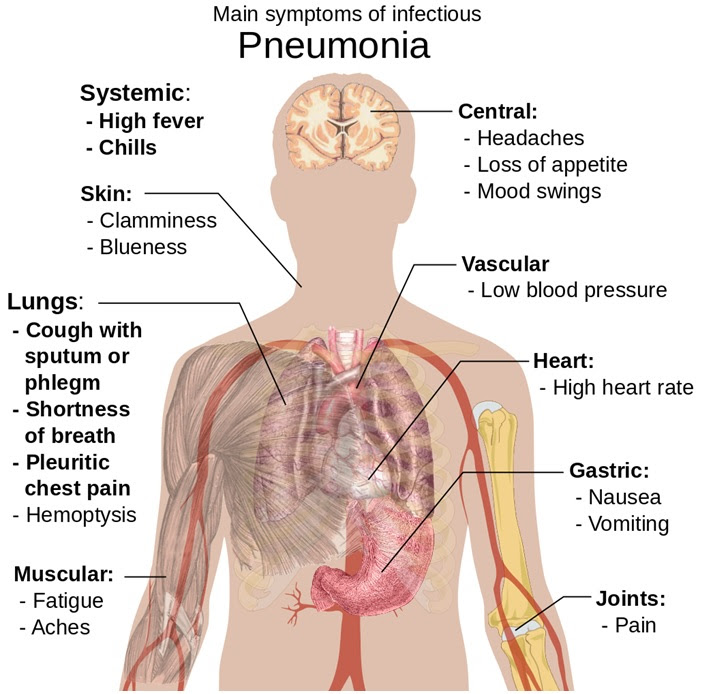

## 1. 프로젝트 목표
## 개인 목표 
* 기존에 배운 이미지 데이터를 대상으로한 CNN 모델들을 적용해본다. (V)
* 나만의 모델 구현 코드를 표준화(?)한다. (V)
    - 데이터셋 구성(load, labeling, augmentation)
    - 이미지 데이터 시각화 
    - 모델 구현 코드(early stopping, checkpoints, learning rate scheduler)
    - 훈련 결과 시각화(accuracy, ~image prediction~)
* 불균형 데이터셋과 Image Augmentation, Model layer에 대한 이론을 정리한다. (V)

## 루브릭
* 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. 
    - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다. (V)  
    
* 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다. 
    - regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 **ablation study** 형태로 체계적으로 수행되었다. (V)
        - 시도: Epochs 수 조절, Early stopping으로 과적합 방지, Checkpoint로 최고 성능 나온 모델 저장, 필터 개수 추가, \
        학습률 조절, weight balancing 조절 

> ablation study란? 성능에 영향을 주는 많은 요인들을 제거하거나, 변형하면서 각 요인들이 최종 성능에 미치는 영향을 비교하는 실험방법이다. 

* 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다. 
    - Accuracy 기준 85%에 도달하였다. (V)

## 2. 프로젝트 구성 


In [47]:
# !pip install tensorflow-gpu==2.2.0

In [48]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import random # Random seed 설정을 위한 패키지 

import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지

import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
from tensorflow import keras  # 딥러닝 관련된 작업에 필요한 패키지

import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지

from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [49]:
tf.__version__

'2.2.0'

## Step 1. 실험환경 Set-up

In [4]:
# !pip install tensorflow-determinism # tensorflow 2.0 버전에 적용 가능 

In [56]:
SEED = 375

In [57]:
# random seed 
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
# 주의사항 ! 
# 중간 중간, seed를 설정해줘야하는 옵션이 있을때, 그 때마다 또 설정해주는 편이 좋음 

In [58]:
## tensorflow 2.0 버전에만 적용 가능 
# import logging

# def set_global_determinism(seed=SEED, fast_n_close=False):
#     """
#         Enable 100% reproducibility on operations related to tensor and randomness.
#         Parameters:
#         seed (int): seed value for global randomness
#         fast_n_close (bool): whether to achieve efficient at the cost of determinism/reproducibility
#     """
    
#     set_seeds(seed=seed)
#     if fast_n_close:
#         return

#     logging.warning("*******************************************************************************")
#     logging.warning("*** set_global_determinism is called,setting full determinism, will be slow ***")
#     logging.warning("*******************************************************************************")

#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#     # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
#     tf.config.threading.set_inter_op_parallelism_threads(1)
#     tf.config.threading.set_intra_op_parallelism_threads(1)
#     from tfdeterminism import patch
#     patch()
    
# set_global_determinism(seed = SEED)

In [59]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# 데이터 경로 변수 
DATA_PATH = os.path.join(ROOT_PATH, 'chest_xray')

# BATCH_SIZE 변수
BATCH_SIZE = 16 # 데이터 개수가 많지 않아서 적은 배치로 살펴보는게 나을 수 있다. 16-> 32 -> 16 

# X-RAY 이미지 사이즈 변수 => Resize해주기 위한 image size 설정 
IMAGE_SIZE = [224, 224] # 실제 이미지는 1000 pixel이 넘는다. 매우 고해상도 이미지, GPU 자원과 성능간 고려해서 적절하게 설정 

# EPOCH 크기 변수
EPOCHS = 30

print(ROOT_PATH)
print(DATA_PATH)

/home/aiffel-dj19/aiffel
/home/aiffel-dj19/aiffel/chest_xray


## Step 2. 데이터 준비하기
1. 데이터 개수 확인 => 데이터셋 개수 충분한지 확인 
2. 데이터 라벨 정보 추출 => 데이터셋 불균형 확인

### 데이터 개수 확인 
* 파일 경로의 데이터 개수 확인한다.
    - tf.io.gfile.glob 함수 활용 
* 데이터 개수 적을시 합친 후 다시 Split

In [60]:
# 경로에 해당하는 파일 개수 세기 
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation set의 데이터 개수가 너무 적다. train과 val path에 있는 데이터를 합해준 후 다시 split해준다. 

In [61]:
# 2개 경로의 파일 합치기 
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

In [62]:
# Data Split
# train, test(val) dataset으로 분할. test_size(val size)에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.1)
print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

4708
524
624


### 데이터 라벨 정보 추출 
* 파일 경로를 바탕으로 폴더명이 가지는 라벨을 추출한다. 
    - split 활용
* 라벨별 개수를 센다. 
    - 만약 불균형하다면, upsampling이나 weight balancing을 진행한다. 

#### 폴더명 활용한 라벨 추출

In [63]:
# data type 확인 
print(type(train_filenames))

<class 'list'>


In [64]:
# 파일 경로에서 라벨값 확인 및 라벨값 반환 
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) # '/'를 기준으로 split
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 바꾼다.
    img = tf.image.convert_image_dtype(img, tf.float32) # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
    return tf.image.resize(img, IMAGE_SIZE) # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  
def process_path(file_path):
    label = get_label(file_path) # class를 알려주는 폴더명을 기준으로 1(True),또는 0(False)으로 labeling 
    img = tf.io.read_file(file_path) # 파일 읽기 
    img = decode_img(img) # image 정규화 및 리사이즈 
    return img, label

#### 폴더 명에서 클래스 이름 가져오기

In [65]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)
print(type(CLASS_NAMES))

['NORMAL' 'PNEUMONIA']
<class 'numpy.ndarray'>


In [66]:
for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*")): # 해당 경로의 하위 폴더 경로 하나씩 가져온다. 
    print(item)

/home/aiffel-dj19/aiffel/chest_xray/train/NORMAL
/home/aiffel-dj19/aiffel/chest_xray/train/PNEUMONIA


In [67]:
str(tf.strings.split(item, os.path.sep)) # 경로를 경로 구분자(seperator)인 bar를 기준으로 split한다. 

"tf.Tensor([b'' b'home' b'aiffel-dj19' b'aiffel' b'chest_xray' b'train' b'PNEUMONIA'], shape=(7,), dtype=string)"

In [68]:
tf.strings.split(item, os.path.sep[-1]) # split한 결과의 맨 뒤 요소 가져온다. 

<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'', b'home', b'aiffel-dj19', b'aiffel', b'chest_xray', b'train',
       b'PNEUMONIA'], dtype=object)>

In [69]:
str(tf.strings.split(item, os.path.sep)[-1].numpy())

"b'PNEUMONIA'"

In [70]:
str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] # b'를 제외하고 3번쨰(index=2) 요소부터 맨끝 요소 빼고 indexing

'PNEUMONIA'

#### 데이터셋 label별 개수 

In [71]:
# 데이터셋 label별 개수 확인 
def label_cnts(data_type : str, data_files : list, label_name : str):
    count = len([filename for filename in data_files if label_name in filename])
    print(f'{label_name } count in {data_type} set: {str(count)}')
    return count

In [72]:
# tensor 형태로 변환 
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy() # Dataset의 개수 세기 
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print("Training images count: " + str(TRAIN_IMG_COUNT))

Training images count: 4708


In [73]:
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print("Validating images count: " + str(VAL_IMG_COUNT))

Validating images count: 524


In [74]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("Testing images count: " + str(TEST_IMAGE_COUNT))

Testing images count: 624


In [75]:
# train 데이터셋 label별 개수 확인 
label_name = "NORMAL"
COUNT_NORMAL = label_cnts('train', train_filenames, label_name)

label_name = "PNEUMONIA"
COUNT_PNEUMONIA = label_cnts('train', train_filenames, label_name)

NORMAL count in train set: 1216
PNEUMONIA count in train set: 3492


In [76]:
# valid 데이터셋 label별 개수 확인 
label_name = "NORMAL"
label_cnts('valid', val_filenames, label_name)

label_name = "PNEUMONIA"
label_cnts('valid', val_filenames, label_name)

NORMAL count in valid set: 133
PNEUMONIA count in valid set: 391


391

In [77]:
# test 데이터셋 label별 개수 확인 
label_name = "NORMAL"
label_cnts('test', test_filenames, label_name)

label_name = "PNEUMONIA"
label_cnts('test', test_filenames, label_name)

NORMAL count in test set: 234
PNEUMONIA count in test set: 390


390

`위의 결과를 통해 폐렴인 경우의 데이터셋이 훈련셋에서 많고, 그에 비해 음성의 경우의 이미지 개수가 적음을 알 수 있다.`

#### 데이터 Shape 및 label 확인 

In [78]:
# Dataset의 shape, label 확인 
for image, label in train_ds.take(1): # 1개 확인 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  True


In [79]:
# Dataset의 shape, label 확인 
for image, label in train_ds.take(3): # 3개 확인 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  True
Image shape:  (224, 224, 3)
Label:  True
Image shape:  (224, 224, 3)
Label:  True


#### 데이터 증강(Augmentation)

In [80]:
# Data Augmentation 이미지를 다양하게 해줄 뿐, 개수를 늘리는 Augmentation은 다르게 해줘야함.
def augment(image,label):
#     image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=3000):
#     augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=AUTOTUNE
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

`데이터의 개수가 증가하는 것이 아니라, flip left right가 랜덤하게 적용되어 데이터셋의 다양성을 증가시킨 것이다.`

In [81]:
# batch로 나눠준 후에, Dataset의 shape, label 확인 
for image, label in train_ds.take(1): # 1개 확인 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 224, 224, 3)
Label:  [ True  True  True False  True False  True  True  True  True  True False
  True  True  True  True]


`배치 크기만큼 차원이 늘어났다.`

## Step 3. 데이터 시각화

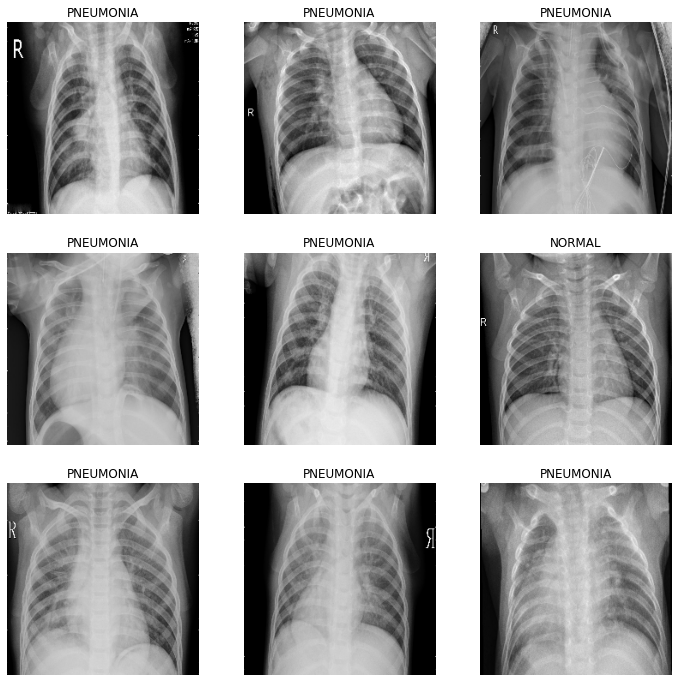

In [82]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(9):
        ax = plt.subplot(3,3,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링
깊이별 합성곱 - 참고 블로그: https://subinium.github.io/Keras-7/

In [83]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()        
    ]
    )
    
    return block

In [84]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [85]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
#         dense_block(128, 0.5),
        dense_block(128, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [86]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4708
Validating images count: 524


In [87]:
## 기존 코드 방식 - 결과값은 동일 
# COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
# print("Normal images count in training set: " + str(COUNT_NORMAL))

# COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
# print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

In [88]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [89]:
from tensorflow.keras.models import load_model #저장된 가중치 불러오기 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # 빨리 끝내기, 체크포인트 모델 파일 저장

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cp_callback = tf.keras.callbacks.ModelCheckpoint(DATA_PATH + '/model',
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [90]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 32)        2816      
_________________________________________________________________
sequential_8 (Sequential)    (None, 14, 14, 64)        7392      
_________________________________________________________________
sequential_9 (Sequential)    (None, 7, 7, 128)       

In [91]:
# 학습률을 점점 줄이기 위한 함수
# 필요한 함수를 직접 정의하여 사용할 수 있습니다.
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

In [92]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es,cp_callback, tf.keras.callbacks.LearningRateScheduler(decay)]
    )

Epoch 1/30
293/294 [============================>.] - ETA: 0s - loss: 0.3453 - accuracy: 0.8375 - precision: 0.9572 - recall: 0.8174
Epoch 00001: val_accuracy improved from -inf to 0.74609, saving model to /home/aiffel-dj19/aiffel/chest_xray/model
294/294 [==============================] - 18s 62ms/step - loss: 0.3446 - accuracy: 0.8378 - precision: 0.9574 - recall: 0.8177 - val_loss: 0.6017 - val_accuracy: 0.7461 - val_precision: 0.7461 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/30
294/294 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9196 - precision: 0.9741 - recall: 0.9161
Epoch 00002: val_accuracy did not improve from 0.74609
294/294 [==============================] - 17s 59ms/step - loss: 0.2076 - accuracy: 0.9196 - precision: 0.9741 - recall: 0.9161 - val_loss: 1.3395 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/30
294/294 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9339 - precision:

`E2하면서 정리했던 confusion matrix`
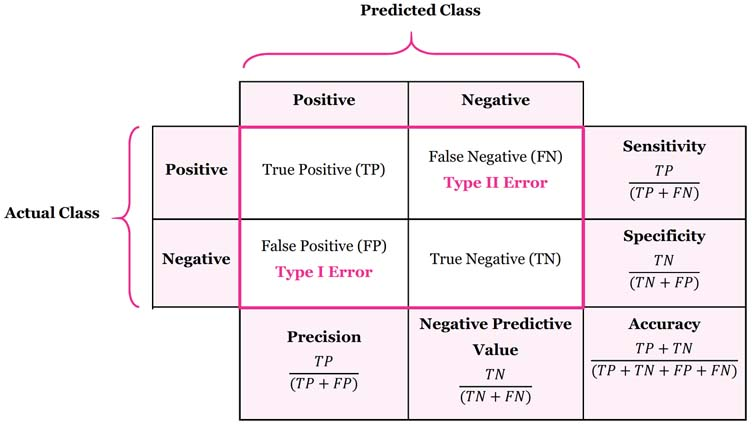
* 참고 링크: https://datascienceschool.net/03%20machine%20learning/09.04%20%EB%B6%84%EB%A5%98%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80.html    
* 참고 링크: https://gaussian37.github.io/ml-concept-ml-evaluation/    
* Confusion Matrix(CM)
    - 정확도(accuracy): 전체 샘플 중 맞게 예측한 샘플 수의 비율 
    - 정밀도(precision): 양성 클래스에 속한다고 판단된 출력 샘플 중 실제로 양성 클래스에 속하는 샘플 수 의 비율(e.g. 판단된 사기 거래 중 실제 사기라고 예측된 비율)
    - 재현율(recall, sensitivity): 실제 양성 클래스에 속한 샘플 중 양성 클래스에 속한다고 출력한 샘플 수의 비율
    - 특이도(=위양성율, fall-out, specificity): 실제 양성 클래스에 속하지 않는 샘플 중 양성에 속한다고 출력한 샘플의 비율

## STEP 5. 학습 결과 확인 

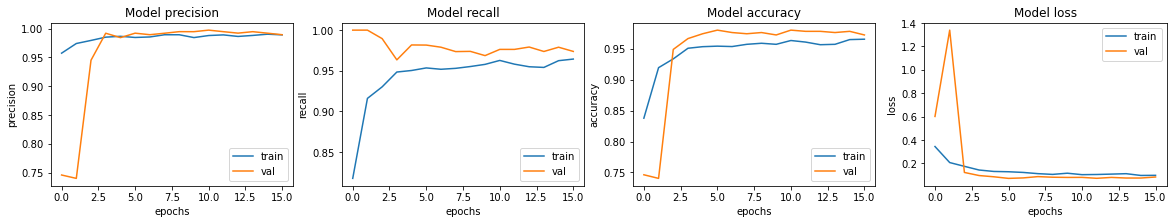

In [93]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

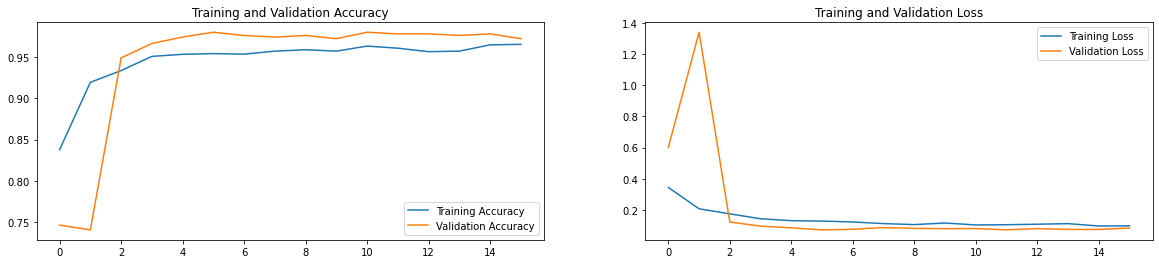

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [95]:
# early stopping으로 종료된 마지막 Epoch에 학습된 모델 
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.5848 - accuracy: 0.7917 - precision: 0.7539 - recall: 0.9897


In [96]:
# callbacks을 통해 val_accuracy 최고점수인 Epoch에 학습된 모델 저장된 가중치 불러와서 evaluate
model.load_weights(DATA_PATH + '/model')
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 63ms/step - loss: 0.5619 - accuracy: 0.7917 - precision: 0.7569 - recall: 0.9821


validation과 test가 가진 데이터 개수 차이가 좀 있어서 그런지 아무래도 validation이 검증의 역할을 엄청 잘 수행해줬다 보기 어려운 모델 학습이었다. 위의 결과에서도 보면 validation이 더 높지만 test set에서는 그러지 못하다. validation set은 어느정도 test set과 비슷한 데이터 분포를 띄어야 이후 evaluation에서 모델이 예상한대로 성능이 나온다는 점을 알 수 있었다. 

#### 문제점 해결과정
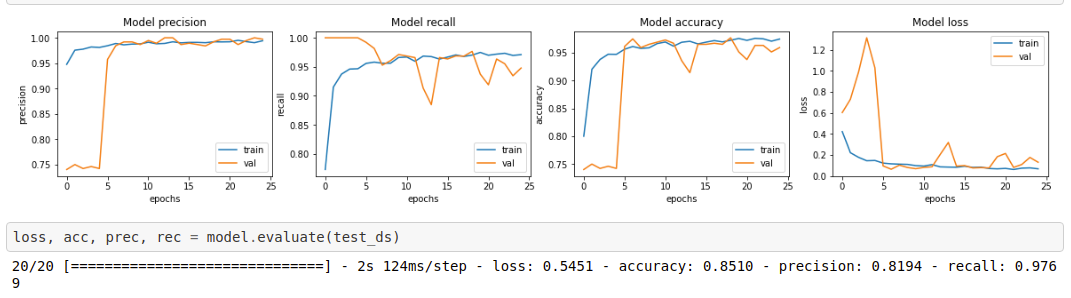
처음에 batch랑 조절해주면서 85점을 얻었다. 하지만, 이후에 layer 수정하는 과정에서 오히려 정확도가 떨어지는 현상이 있었다. 여러 실험을 해보기 위해 해당 파일은 `[E-14]PneumoniaClassification_origin`로 깃허브에 빼두고 여러 파라미터를 실험해봤다. 
훈련 결과 validation 결과가 높게 나와도 test 결과에서 점수가 20% 정도 차이가 남을 확인했습니다. 명확한 검증을 위해 validation 비중을 10%->15%->20% 높여주고 다시 훈련시켰습니다. 
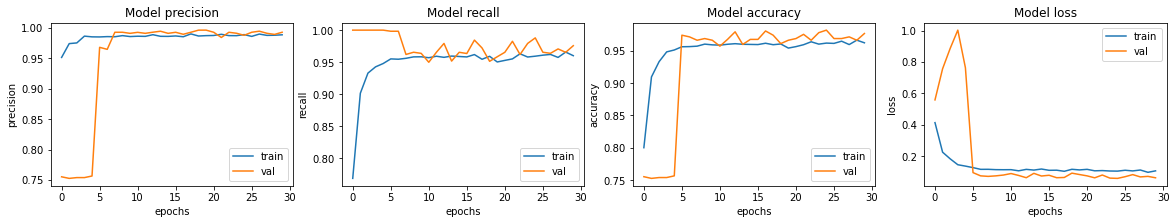
20/20 [==============================] - 2s 109ms/step - loss: 0.6670 - accuracy: 0.7676 - precision: 0.7333 - recall: 0.9872 <br>
비중을 늘려도 정확도가 오르지 않아, 이전에 해줬던 Dropout 0.7 -> 0.5 -> 0.7로 수정했다. <br>
Dropout을 조절해준 뒤에는 20/20 [==============================] - 2s 115ms/step - loss: 0.6254 - accuracy: 0.7869 - precision: 0.7485 - recall: 0.9923과 같은 경과가 나와 이전보다 성능 개선이 이뤄졌음을 확인할 수 있었습니다. <br>
모델에서 필터 개수를 16->32로 수정하고 이미지 크기를 좀더 큰 250x250으로 리사이즈를 진행했다. <br> 
20/20 [==============================] - 33s 2s/step - loss: 0.6317 - accuracy: 0.7420 - precision: 0.7101 - recall: 0.9923 결과적으로 더 낮은 정확도를 얻었다. <br>
random_seed를 조정해가면서 20/20 [==============================] - 29s 1s/step - loss: 0.5495 - accuracy: 0.7837 - precision: 0.7495 - recall: 0.9821과 같은 결과를 얻었고 다른 seed=375, 444 등으로 변경해가며 다시 훈련해봤습니다.
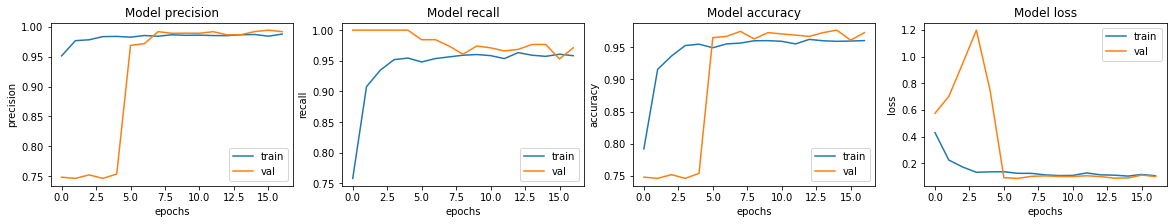
20/20 [==============================] - 2s 114ms/step - loss: 0.5928 - accuracy: 0.7708 - precision: 0.7352 - recall: 0.9897와 같이 비슷한 결과가 나왔습니다. 그래서 conv 함수를 추가해서 conv layer를 2개 정도 추가해줬습니다. 오히려, layer를 추가하니 18/20 [==========================>...] - ETA: 0s - loss: 0.7891 - accuracy: 0.7326 - precision: 0.7053 - recall: 0.9890 결과 성능이 나빠졌다. 처음의 magic number인 375가 가장 성능은 괜찮ㄱ게 나왔다. 39/39 [==============================] - 2s 63ms/step - loss: 0.5619 - accuracy: 0.7917 - precision: 0.7569 - recall: 0.9821


In [45]:
# # 특정 index번째 데이터 추론(predict)한 결과 확인
# predicted_result = model.predict(test_ds.take(1))  # model이 추론한 확률값. 
# predicted_labels = np.argmax(predicted_result, axis=1)

# idx=0  #1번째 x_test를 살펴보자. 
# print('model.predict() 결과 : ', predicted_result[idx])
# print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
# print('실제 데이터의 라벨 : ', y_test[idx])

# plt.imshow(x_test[idx],cmap=plt.cm.binary)
# plt.show()

In [46]:
# # 잘못 추론(predict)한 결과 확인
# wrong_predict_list=[]
# for i, _ in enumerate(predicted_labels):
#     # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
#     if predicted_labels[i] != y_test[i]:
#         wrong_predict_list.append(i)

# # wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
# samples = random.choices(population=wrong_predict_list, k=5)

# for n in samples:
#     print("예측확률분포: " + str(predicted_result[n]))
#     print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
#     plt.imshow(x_test[n], cmap=plt.cm.binary)
#     plt.show()

## 회고 (분류 모델 지금까지 궁금했던거 정리) 
이번 노드를 통해서 지금까지 이미지 분류기로 해본 내용들을 종합적으로 정리하는 시간을 가졌습니다. 그때 그때 노드에서 적용했던 방법들을 합해서 추후에 다양하게 활용해볼 수 있도록 했습니다. 

### STEP 1에서 Random seed는 왜 고정해줘야하는가? 어차피 결과 유지는 똑같이 안되는데? 
컴퓨터는 여러 random seed 안에서의 알고리즘으로 난수를 발생시킨다. 학습시킬 때 어느 정도 고정된 결과를 보기 위해서는 일정한 Input을 줄 필요가 있는데, 이때 Random seed를 고정해줘서 batch를 만들때나 이러한 입력 데이터가 형성되거나 Shuffle될 때 실행할때마다 같은 난수의 패턴으로 입력 셋을 형성하도록 해주기 위해 Random seed를 사용한다. 그러나 Seed를 설정하더라도 이에 영향받지 않는 random seed를 cuda에서 참고하는 함수도 있을 수 있다. 그러다보니, seed를 고정해줘도 결과가 항상 다르게 나오는 것이다. 그럼 정말 고정적으로 random을 determine하게 할 수 있는 방버은 없을까? 했을때 있었다. 글로벌하게 seed를 설정해주면 random을 통제할 수 있다!
* 참고 블로그1: https://hoya012.github.io/blog/reproducible_pytorch/
* 참고 블로그2: https://suneeta-mall.github.io/2019/12/22/Reproducible-ml-tensorflow.html
* 참고 블로그3: https://jackd.github.io/posts/deterministic-tf-part-2/

> Following are some of the application of Tensorflow that are not reproducible: (1) Backward pass of broadcasting on GPU is non-deterministiclink, (2) Mention that GPU reductions are nondeterministic in docslink, (3) Problems Getting TensorFlow to behave Deterministicallylink
 
### STEP 1에서 데이터는 항상 균형적인게 좋은걸까? 
그렇다. 균형적이지 못한 데이터셋으로 정확도가 높게 나오는 경우는 1인 경우가 많은 경우를 학습시켰는데, test set에 그에 맞게 1만 주로 데이터가 제공될때 이다. 하지만 정확도가 높게 나왔다고해서 좋은 모델이 아니다. 이러한 불균형 셋에서는 true positive(recall)가 높도록 모델을 최적화해줄 필요가 있다.

### STEP 1에서 불균형한 데이터셋을 균형적으로 하게 해주는 다른 방법은? 
비지도 학습 기법을 활용하여 주로 불균형셋을 균형적으로 sampling해주기도 한다. Oversampling에는 SMOTE, undersampling에는 Tomek links가 활용된다. 적은 데이터 개수를 가진 클래스(라벨)에 대해 임의의 Knn(최근접 이웃)데이터들을 추가하는 방법이다. 과적합될 수 있어 새로운 사례에 대한 데이터 예측을 취약할 수 있다. 그리고 Downsampling은 서로 다른 클래스에 속하는 한쌍씩 데이터를 묶어주고 그 중에서 다수 데이터를 제거하는 기법이다. 그러나 이 방법은 데이터 손실 문제를 가지고 있다. 이외에도 Weight balancing과 같이 적은 데이터 개수를 가진 라벨에 대해 높은 가중치를 부여하여 학습하는 방법도 있다. 
* 참고 블로그: https://sherry-data.tistory.com/22

### STEP 1에서 데이터셋이 작을 때, 어떤 접근 방법이 필요한가? 
#### 방법1. Data Augmentation - 데이터의 다양성과 개수 늘리기 
*tf.keras.preprocessing.image.ImageDataGenerator*

```
# 다양성 늘리기 
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

# 데이터 개수 늘리기 
ImageDataGenerator.flow ~
```
**여기서 주의사항은 Validation set에 대해서는 augmentation을 하면 안된다.**
#### 방법2. Transfer learning & Fine tuning using pretrained model 
적은 데이터셋을 가지고 있을 때는 비슷한 클래스를 가진 기존에 CNN 모델로 사전 학습된 모델들로 가중치를 가져와 전이학습 혹은 미세조정해주면 된다. 
* 참고 블로그: http://blog.skby.net/%EC%A0%84%EC%9D%B4-%ED%95%99%EC%8A%B5-transfer-learning/

### STEP 1에서 왜 이미지 사이즈 224, 224 인가? 
CNN 모델들인 Resnet 등과 같은 모델들은 최소 이미지 사이즈를 224x224를 요구한다. 모델 layer가 10개 이상 넘어가는 Resnet18, 50 등과 같이 점점 Downsampling 되는 특징이 있는 Conv layer 같은 경우 이미지 사이즈가 적정 크기를 갖는 것이 중요하다. 따라서 기존 180x180보다 224x224로 최소 요건을 만족시켜준다. 더 크게 하지 않는 이유는 GPU가 2080이니까.. 그 이상은 Epoch이나 다른 파라미터를 위해.. 최소요건만 만족시켜준다.

### Step 2에서 라벨 정보가 있는 csv 파일없이, 이미지 파일 각각의 라벨값을 어떻게 알 수 있을까? 
csv로 라벨 정보가 나와있는 경우도 있고, 파일명에서 _ 다음으로 나오는 라벨명을 추출해야하는 경우도 있다. 이번 데이터셋 같은 경우 라벨이 폴더명으로 되어있는 경우에 폴더 경로에서 폴더명을 추출하고 해당 폴더명을 라벨로 사용하는 경우이다. 

### STEP 2에서 tensorflow.data.Dataset.from_tensor_slices은 어떤 역할일까? 
~메모리에 존재하는 데이터로 Dataset을 구성하는 경우, 해당 함수를 통해 이미지 파일 등을 데이터셋 객체로 만들어 줄 수 있다.~ from_tensor라면 데이터의 전체를 저장하는 것이고, slices는 전체 데이터를 쪼개서 저장하는 것이다. 
* 참고 블로그: https://locslab.github.io/Tensorflow-Dataset-API(2)/

### STEP 4에서 다른 방법으로 API 구현해본다면?
* Sequential API - 모델 연결성 확인할 때 좋음 
* 함수형 API - 복잡한 입출력 가질 때 사용하면 좋음 
* Subclassing API - train과 test할 때 layer의 구성을 다르게 가져갈 수 있음 (V)

### STEP 5에서 왜 fit, compile 대신 굳이 Gradiend Tape를 써줄까?
좀더 미세한 조정을 위해서 fit의 단계를 gradient tape로 해주기도 한다. 이렇게 됐을때 중간 결과를 가지고 사용할 수 있어서 좋다 .

### 지금까지 진행한 이미지 분류 프로젝트와 비교한다면?
지금까지 진행한 프로젝트에서는 데이터셋은 대부분 균형적이었다. 그리고 라벨별로도 균형적으로 데이터가 구성되어있었다. 그리고 고해상도 이미지 보다는 28x28로 작은 손글씨나, 흑백 이미지를 주로 다루었다. 혹은 컬러 이미지를 다루더라도 resize로 크기를 줄여서 진행했다면 이번 의료 이미지 데이터는 이미지 크기가 크고, 의료 이미지는 주로 해상도를 크게 해서 분류하는 것이 좀더 정확도가 높아 CNN 모델들이 주로 최소로 요구하는 224 이미지 사이즈를 주고 모델링했다. 뿐만 아니라, 지금까지 모델 구현 중에 가장 많은 layer를 쓴거 같다. 
#### E1 이미지 분류기 
* 데이터셋: mnist, 가위바위보 
* 데이터셋 특징: mnist는 흑백, 가위바위보는 컬러 이미지였고, 데이터가 균형적으로 구성, label은 다수개였음. 
* 사용 모델: Convolution layer로 이뤄진 6~7 layers

#### E2 이미지 분류기 
* 데이터셋: sklearn의 digits(손글씨)
* 데이터 특징: 흑백 이미지였고, 데이터가 균형적으로 구성, label은 다수개였음. 
* 사용 모델: 선형 분류기(SVM 등)


## 응용? 
아래 두개는 좀더 공부해야할 부분이다. 이미지 데이터 특성을 알기위해 시각화하는 방법 말고, 먼가 이미지 데이터가 잘 랜덤하게 split되었는지 확인해보거나 이미지 특성이 특이한거? 이상치라고 해야하나.. 그런걸 데이터 전처리 단계에서 알 수 있는 방법이 없을까? 궁금하다. 

### STEP 3에서 이미지 데이터의 특성을 분석해볼 수 있는 방법은 없나?
### 데이터의 특성을 사전에 알기 위해 선형분류기를 적용해보기도 한다, 그 이유는 무엇일까?
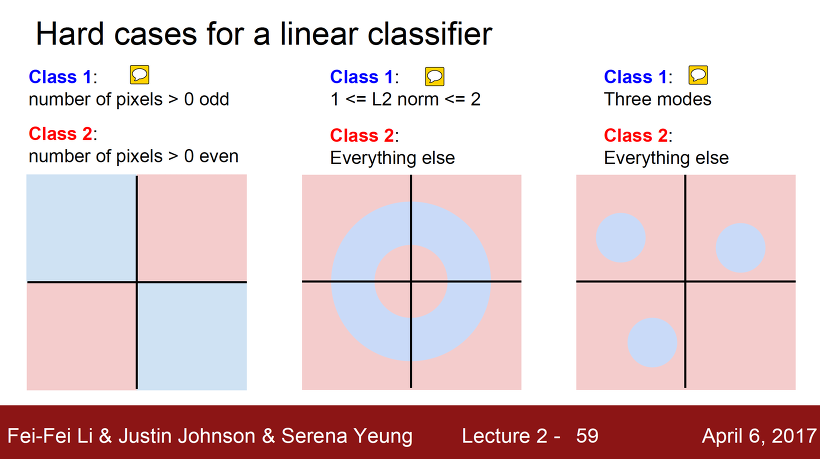
cs231n에서 선형분류기에 대해 잠깐 다뤘었는데, 선형분류기는 아래 그림처럼 결정 결계(decision boundary)를 가지고서 각 클래스를 구분한다. 만약에 이미지 데이터가 선형분류기로 모델을 돌렸을 때 정확도가 높지 않다면? 위에 사진처럼 선형 분류기로 분류하기 어려운 데이터셋이라고 볼 수 있다. 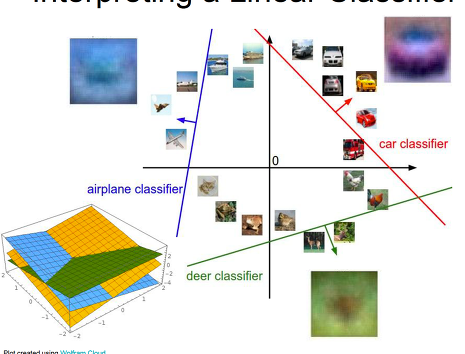
이렇게 살펴보면 좋은 점은 가끔 이미지 분류를 할때 누락되는 클래스가 있는 경우가 있는데, 그럴때 선형분류기로 데이터의 선형성을 확인해보면서 튀는 특징을 가진? 클래스를 찾을 수 도 있다고 데이터 카톡방(?)에서 알려줬었다. => 정확히 맞는 부분인지 검색해도 잘 안나와서 더 공부해봐야겠다. 
* 참고 블로그: https://bskyvision.com/851 (SVM에 대한 자료)